## Pre-Processing

In [161]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/piyushghai/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
#This was run to convert the json to csv. The parser was supplied along with the dataset, obtained from : https://www.yelp.com/dataset_challenge

#%#run json_to_csv_converter.py "Data/yelp_academic_dataset_business.json"
#%run json_to_csv_converter.py "Data/yelp_academic_dataset_review.json"

In [4]:
#All the imports in one place

import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score


plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

/Users/piyushghai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/piyushghai/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.1

In [5]:
def getReducedDataFrame():
    business_data = pd.read_csv("Data/yelp_academic_dataset_business.csv", dtype=unicode)
    review_data = pd.read_csv("Data/yelp_academic_dataset_review.csv")
    len(review_data)
    len(business_data)
    #We are targetting reviews related to restaurants only
    resto_business_data = business_data[business_data['categories'].str.contains('Restaurants')]
    len(resto_business_data)
    #Merging review data along with business data based on business id.
    resto_review_data = review_data.merge(resto_business_data,
                                         left_on='business_id',
                                         right_on='business_id',
                                         suffixes=('_review', '_business'))
    list(resto_review_data)
    #Stripping out everything else and just keeping the text of reviews and star rating
    resto_review_data = resto_review_data.ix[:,['text','stars_review']]
    return resto_review_data

In [6]:
#Stripping out everything else and just keeping the text of reviews and star rating
resto_review_data = getReducedDataFrame()

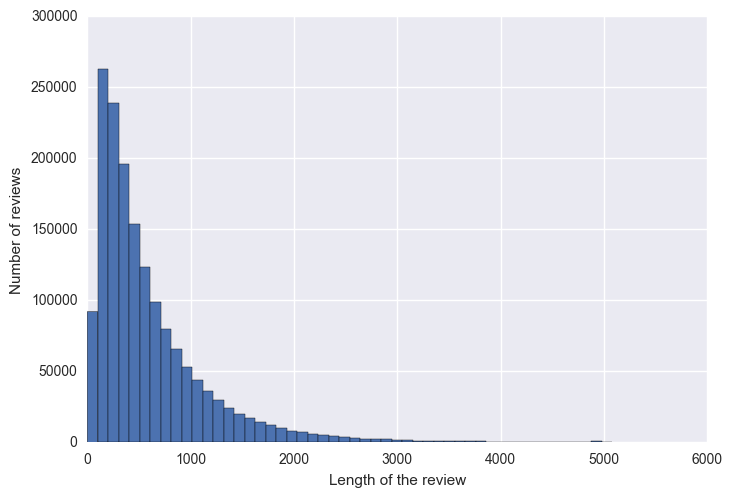

In [79]:
resto_review_data.text.dropna().str.len().hist(bins=50)
xlabel('Length of the review')
ylabel('Number of reviews')

In [7]:
def reduceReviewBasedOnLength(resto_review_data, minReviewLen, maxReviewLen) :
    resto_review_reduced = resto_review_data[resto_review_data.text.str.len() > minReviewLen]
    len(resto_review_reduced)
    resto_review_reduced = resto_review_reduced[resto_review_reduced.text.str.len() < maxReviewLen]
    return resto_review_reduced
    

In [9]:
resto_review = reduceReviewBasedOnLength(resto_review_data= resto_review_data, minReviewLen=50, maxReviewLen=500)
len(resto_review)

910340

In [10]:
### Optional :  Sampling : 
resto_review = resto_review.sample(100000)

In [ ]:
pickle.dump(resto_review, open("resto_review.p", "wb"))

In [24]:
#Convert stars to float
resto_review.stars_review = resto_review.stars_review.astype(float)

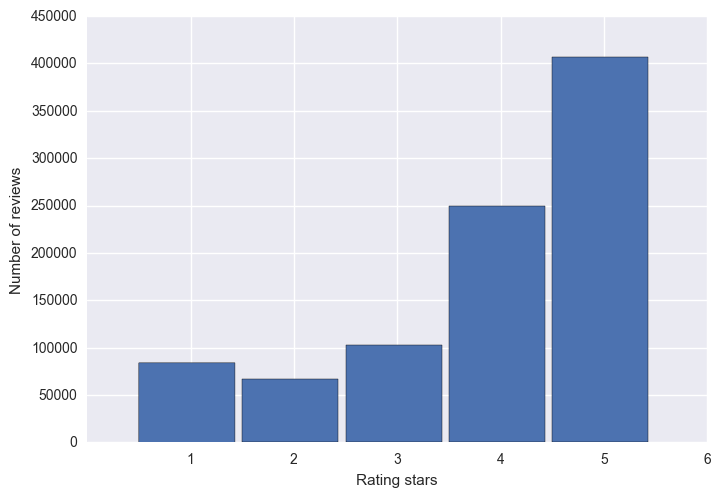

In [96]:
bins = [1, 2, 3 ,4, 5, 6]
resto_review.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

## Baseline Model

In [11]:
## The baseline model will be a dumb model based purely on the averages
review_data = resto_review
review_data['predicted_rating'] = round(sum(review_data.stars_review)/len(review_data.index))


Baseline Rating: 3.0


In [ ]:
print "Baseline Rating:", round(sum(review_data.stars_review)/len(review_data.index))

In [13]:
len(review_data)

100000

In [14]:
precision = metrics.precision_score(review_data.stars_review, review_data.predicted_rating)
recall = metrics.recall_score(review_data.stars_review, review_data.predicted_rating)
f1 = metrics.f1_score(review_data.stars_review, review_data.predicted_rating)
accuracy = accuracy_score(review_data.stars_review, review_data.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with mul

,accuracy,f1_score,precision,recall
Baseline,0.11356,0.023162,0.012896,0.11356


## Model 1 - Rating prediction from Topics extracted from reviews using LDA

In [15]:
## Get the stopwords for preprocessing

NLTK_STOPWORDS = set(stopwords.words('english'))
MORE_STOPWORDS = set([line.strip() for line in open('more_stopwords.txt', 'r')])

In [17]:
## NLTK pipeline

def lowercase(s):
    return s.lower()

def tokenize(s):
    token_list = nltk.word_tokenize(s)
    return token_list

def remove_punctuation(s):
    return s.translate(None, string.punctuation)

def remove_numbers(s):
    return s.translate(None, string.digits)
 
def remove_stopwords(token_list):
    exclude_stopwords = lambda token : token not in NLTK_STOPWORDS
    return filter(lambda tok : tok not in MORE_STOPWORDS, filter(exclude_stopwords, token_list))

def stemming_token_list(token_list):
    STEMMER = PorterStemmer()
    return [STEMMER.stem(tok.decode('utf-8')) for tok in token_list]

def restring_tokens(token_list):
    return ' '.join(token_list)

In [18]:
# Clean all the reviews by removing stop words as well as punctutation marks
def process_reviews(data_set):
    clean_data_set = []
    for text in data_set:
        text = lowercase(text)
        text = remove_punctuation(text)
        text = remove_numbers(text)

        token_list = tokenize(text)
        token_list = remove_stopwords(token_list)

        token_list = stemming_token_list(token_list)
        
        try:
            clean_data_set.append(restring_tokens(token_list))
        except:
            pass
    return clean_data_set

In [19]:
# Function to create the LDA model from the training dataset.
def perform_lda(train, totalTopics):
    corpus = []
    for text in train:
        text_list = [word for word in text]
        try:
            corpus.apped(text_list)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    # Save the dictionary
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_vector = [dictionary.doc2bow(text) for text in corpus]
    
    lda = models.LdaModel(corpus_vector, num_topics=totalTopics, id2word=dictionary)
    return lda

In [20]:
# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def getTopicDistMatrix(lda, totalTopics, corpus, all_dist, star):
    topic_dist = [0] * totalTopics
    # Load the dictionary
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    # For every reviewDoc in the corpus, compute the prob dist matrix for each term
    for review in corpus:
        vec = dictionary.doc2bow(review.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * totalTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

In [24]:
# Group all reviews per star rating and extract text out of them
starsGroup = resto_review.groupby('stars_review')

text_star_1 = starsGroup.get_group(1.0)['text']
text_star_2 = starsGroup.get_group(2.0)['text']
text_star_3 = starsGroup.get_group(3.0)['text']
text_star_4 = starsGroup.get_group(4.0)['text']
text_star_5 = starsGroup.get_group(5.0)['text']

In [25]:
# Optional : To reduce the dataset size and prevent laptop from frying, reduce the dataset size by sampling
sampling = 1000 # No of rows to be sampled

text_star_1 = text_star_1.sample(sampling)
text_star_2 = text_star_2.sample(sampling)
text_star_3 = text_star_3.sample(sampling)
text_star_4 = text_star_4.sample(sampling)
text_star_5 = text_star_5.sample(sampling)

In [26]:
# Add all the corresponding original labels to reviews
label_star_1 = [1.0]*len(text_star_1)
label_star_2 = [2.0]*len(text_star_2)
label_star_3 = [3.0]*len(text_star_3)
label_star_4 = [4.0]*len(text_star_4)
label_star_5 = [5.0]*len(text_star_5)

In [27]:
from sklearn.cross_validation import train_test_split

# Create test and training dataset. We use 80-20 sampling here. We can use 66-33 sampling too
train_stars_1, test_stars_1, train_labels_stars_1, all_1stars_labels_test = train_test_split(text_star_1, label_star_1, test_size=0.30)
train_stars_2, test_stars_2, train_labels_stars_2, all_2stars_labels_test = train_test_split(text_star_2, label_star_2, test_size=0.30)
train_stars_3, test_stars_3, train_labels_stars_3, all_3stars_labels_test = train_test_split(text_star_3, label_star_3, test_size=0.30)
train_stars_4, test_stars_4, train_labels_stars_4, all_4stars_labels_test = train_test_split(text_star_4, label_star_4, test_size=0.30)
train_stars_5, test_stars_5, train_labels_stars_5, all_5stars_labels_test = train_test_split(text_star_5, label_star_5, test_size=0.30)

In [28]:
print(len(train_labels_stars_1))

700


In [29]:
## Cleaning all the reviews and building corpus out of them
corpus_5stars = process_reviews(train_stars_5)
corpus_4stars = process_reviews(train_stars_4)
corpus_3stars = process_reviews(train_stars_3)
corpus_2stars = process_reviews(train_stars_2)
corpus_1stars = process_reviews(train_stars_1)

NameError: global name 'string' is not defined

In [ ]:
print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

In [ ]:
# Creating combined dataset for training, containing representation of all the 5 star ratings possible
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [ ]:
%time lda = perform_lda(all_text_train, totalTopics)

In [30]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

In [ ]:
topic_dist_5stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_1stars, topic_dist_list, 1)

In [ ]:
cols = []
for i in xrange(1, totalTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

In [ ]:
topic_dist_train_all_stars = pd.DataFrame(topic_dist_list, columns=cols)

In [ ]:
corpus_5stars_test = process_reviews(test_stars_5)
corpus_4stars_test = process_reviews(test_stars_4)
corpus_3stars_test = process_reviews(test_stars_3)
corpus_2stars_test = process_reviews(test_stars_2)
corpus_1stars_test = process_reviews(test_stars_1)

print "Number of 5-star reviews after processing: ", len(corpus_5stars_test)
print "Number of 4-star reviews after processing: ", len(corpus_4stars_test)
print "Number of 3-star reviews after processing: ", len(corpus_3stars_test)
print "Number of 2-star reviews after processing: ", len(corpus_2stars_test)
print "Number of 1-star reviews after processing: ", len(corpus_1stars_test)

In [ ]:
all_5_4_test = np.append(corpus_5stars_test, corpus_4stars_test)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars_test)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars_test)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars_test)

In [ ]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_5stars_test, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_4stars_test, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_3stars_test, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_2stars_test, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_1stars_test, topic_dist_list, 1)

In [ ]:
cols = []
for i in xrange(1, totalTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

In [ ]:
topic_dist_test_all_stars = pd.DataFrame(topic_dist_list, columns=cols)

features = list(topic_dist_train_all_stars.columns[:totalTopics])

In [ ]:
x_train = topic_dist_train_all_stars[features]
y_train = topic_dist_train_all_stars['Star']

x_test = topic_dist_test_all_stars[features]
y_test = topic_dist_test_all_stars['Star'] 

In [28]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
LDA_Prediction_Perf = pd.DataFrame(LDAResults).T[cols].T
LDA_Prediction_Perf

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

In [ ]:
for model, val in LDAResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

# Model 2 - Rating prediction from TFIDF of reviews

In [120]:
# Extracting features using term frequency
tfidfvectorizer = TfidfVectorizer()

tfidfTrain = tfidfvectorizer.fit_transform(all_text_train)
tfidfTest = tfidfvectorizer.transform(all_text_test)

tfidfLabelTrain = topic_dist_train_all_stars['Star']
tfidfLabelTest = topic_dist_train_all_stars['Star']

In [ ]:
classifiers = [MultinomialNB(), LogisticRegression()]
classifiers_names = ['Multinomial Naive Bayes', 'Logistic Regression']

In [ ]:
TFIDF_Pred_Results = {}
for (i, clf_) in enumerate(classifiers):
    clf = clf_.fit(tfidfTrain, tfidfLabelTrain)
    prediction = clf.predict(tfidfTest)
    
    precision = metrics.precision_score(tfidfLabelTrain, prediction)
    recall = metrics.recall_score(tfidfLabelTest, prediction)
    f1 = metrics.f1_score(tfidfLabelTest, prediction)
    accuracy = accuracy_score(tfidfLabelTest, prediction)
    report = classification_report(tfidfLabelTest, prediction)
    matrix = metrics.confusion_matrix(tfidfLabelTest, prediction, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    TFIDF_Pred_Results[classifiers_names[i]] = data


In [ ]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(TFIDF_Pred_Results).T[cols].T

In [ ]:
for model, val in TFIDF_Pred_Results.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

## Model 3 -  Rating prediction from LDA Topics and Sentiment

In [128]:
## Defining Sentiment : If review is < 3 stars, label it as -ve sent, else +ve sent
def getSentiment(x):
    if x < 3.0:
        return 0
    else:
        return 1

In [129]:
topic_dist_train_all_stars['Sentiment'] = topic_dist_train_all_stars['Star'].map(getSentiment)
topic_dist_test_all_stars['Sentiment'] = topic_dist_test_all_stars['Star'].map(getSentiment)

In [ ]:
sentimentTextTrain = tfidfvectorizer.fit_transform(all_text_train)
sentimentTextTest = tfidfvectorizer.transform(all_text_test)

sentimentLabelTrain = topic_dist_train_all_stars['Sentiment']
sentimentLabelTest = topic_dist_test_all_stars['Sentiment']

In [ ]:
classifier = LogisticRegression().fit(sentimentTextTrain, sentimentLabelTrain)

ySentimentTrain = classifier.predict(sentimentTextTrain)
ySentimentTest = classifier.predict(sentimentTextTest)

topic_dist_train_all_stars['Sentiment_Predicted'] = ySentimentTrain
topic_dist_test_all_stars['Sentiment_Predicted'] = ySentimentTest

In [ ]:
features = list(topic_dist_train_all_stars.columns[:totalTopics])
features.append(topic_dist_train_all_stars.columns[totalTopics+2])

In [ ]:
x_train = topic_dist_train_all_stars[features]
y_train = topic_dist_train_all_stars['Star']

x_test = topic_dist_test_all_stars[features]
y_test = topic_dist_test_all_stars['Star'] 

In [ ]:
classifiers = [MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
classifiers_names = ['Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'AdaBoost']

LdaSentimentResults = {}
for (i, clf_) in enumerate(classifiers):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LdaSentimentResults[classifiers_names[i]] = data

In [ ]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(LdaSentimentResults).T[cols].T

for model, val in LdaSentimentResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

 ## Model 4 -  Rating prediction from Bag Of Words

In [174]:
TEST_SIZE = 0.30
train_X, test_X, train_y, test_y = train_test_split(resto_review.text,
                                                    resto_review.stars_review,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)


In [176]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word",
                                          tokenizer = None,    
                                          preprocessor = None,
                                          ngram_range = (1, 1),
                                          binary = False,
                                          strip_accents='unicode')

bigram_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,
                                    preprocessor = None,
                                    ngram_range = (2, 2),
                                    strip_accents='unicode')

trigram_vectorizer = CountVectorizer(analyzer = "word",
                                     tokenizer = None,
                                     preprocessor = None,
                                     ngram_range = (3, 3),
                                     strip_accents='unicode')

bi_and_trigram_vectorizer = CountVectorizer(analyzer = "word",
                                            tokenizer = None,
                                            preprocessor = None,
                                            ngram_range = (2,3),
                                            strip_accents='unicode')


## BOW Model

In [177]:
bag_matrix_train = bag_of_words_vectorizer.fit_transform(train_X)

In [178]:
bag_matrix_test = bag_of_words_vectorizer.transform(test_X)

In [179]:
multinomial_nb_classifier = MultinomialNB()
multinomial_nb_classifier.fit(bag_matrix_train, train_y)
multinomial_nb_prediction = multinomial_nb_classifier.predict(bag_matrix_test)

In [180]:
def make_confusion_matrix_relative(confusion_matrix):
    star_category_classes = [1, 2, 3, 4, 5]
    N = map(lambda clazz : sum(test_y == clazz), star_category_classes)
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(0, len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

# http://www.wenda.io/questions/4330313/heatmap-with-text-in-each-cell-with-matplotlibs-pyplot.html
# http://stackoverflow.com/questions/20520246/create-heatmap-using-pandas-timeseries
# http://sebastianraschka.com/Articles/heatmaps_in_r.html
# http://code.activestate.com/recipes/578175-hierarchical-clustering-heatmap-python/
def plot_confusion_matrix(confusion_matrix=[[]], title='CM', savefilename=''):
    rcm = make_confusion_matrix_relative(confusion_matrix)
    #plt.imshow(rcm, vmin=0, vmax=1, interpolation='nearest')
    c = plt.pcolor(rcm, edgecolors='k', linewidths=4, cmap='jet', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))

    def show_values(pc, fmt="%.2f", **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')
    
    return plt.show()

[[ 0.22916667  0.03125     0.04166667  0.30208333  0.39583333]
 [ 0.0754717   0.01886792  0.03773585  0.49056604  0.37735849]
 [ 0.01052632  0.          0.06315789  0.50526316  0.42105263]
 [ 0.          0.          0.012       0.368       0.62      ]
 [ 0.00492611  0.          0.00246305  0.12068966  0.87192118]]


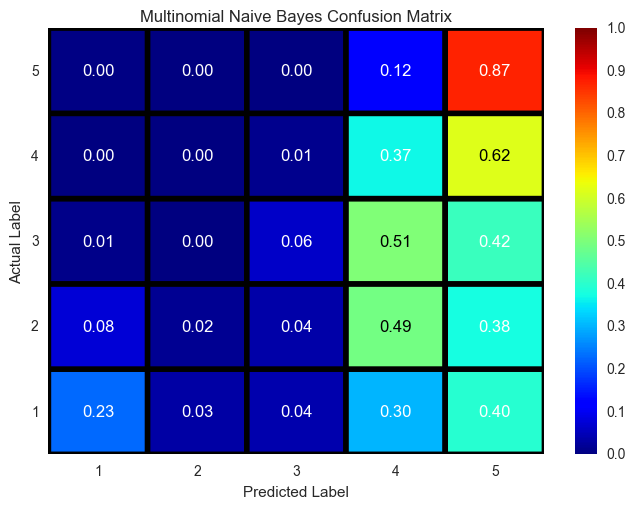

In [181]:
multinomial_confusion_matrix = confusion_matrix(test_y, multinomial_nb_prediction)
print make_confusion_matrix_relative(multinomial_confusion_matrix)
plot_confusion_matrix(multinomial_confusion_matrix, 'Multinomial Naive Bayes Confusion Matrix', savefilename='MultinomialCM.png')

In [182]:
def print_classifier_performance_metrics(name, predictions):
    target_names = ['1 star', '2 star', '3 star', '4 star', '5 star']
    
    print "MODEL: %s" % name
    print

    print 'Precision: ' + str(metrics.precision_score(test_y, predictions))
    print 'Recall: ' + str(metrics.recall_score(test_y, predictions))
    print 'F1: ' + str(metrics.f1_score(test_y, predictions))
    print 'Accuracy: ' + str(metrics.accuracy_score(test_y, predictions))

    print
    print 'Classification Report:'
    print classification_report(test_y, predictions, target_names=target_names)
    
    print
    print 'Precision variance: %f' % np.var(precision_score(test_y, predictions, average=None), ddof=len(target_names)-1)
    
    print
    print 'Recall variance: %f' % np.var(recall_score(test_y, predictions, average=None), ddof=len(target_names)-1)

In [183]:
print_classifier_performance_metrics('Multinomial Naive Bayes', multinomial_nb_prediction)


MODEL: Multinomial Naive Bayes

Precision: 0.503047195574
Recall: 0.527777777778
F1: 0.469776066215
Accuracy: 0.527777777778

Classification Report:
             precision    recall  f1-score   support

     1 star       0.76      0.23      0.35        96
     2 star       0.25      0.02      0.04        53
     3 star       0.38      0.06      0.11        95
     4 star       0.38      0.37      0.37       250
     5 star       0.58      0.87      0.70       406

avg / total       0.50      0.53      0.47       900


Precision variance: 0.162173

Recall variance: 0.471342


/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

## BiGram Naive Bayes Model 

In [184]:
bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)

In [185]:
bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)

In [186]:
bigram_multinomial_nb_classifier = MultinomialNB().fit(bigram_multinomial_feature_matrix_train, train_y)
bigram_multinomial_nb_prediction = bigram_multinomial_nb_classifier.predict(bigram_multinomial_feature_matrix_test)

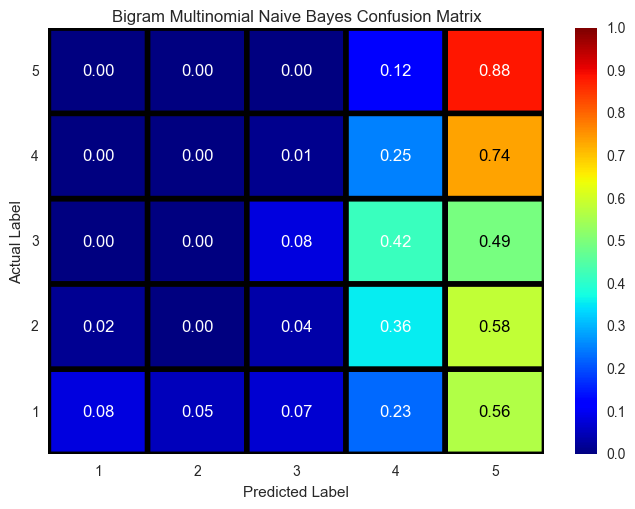

In [187]:
bigram_multinomial_confusion_matrix = confusion_matrix(test_y, bigram_multinomial_nb_prediction)
plot_confusion_matrix(bigram_multinomial_confusion_matrix, 'Bigram Multinomial Naive Bayes Confusion Matrix', savefilename='BigramMultinomialCM.png')

In [188]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes', bigram_multinomial_nb_prediction)


MODEL: Bigram Multinomial Naive Bayes

Precision: 0.468584353522
Recall: 0.486666666667
F1: 0.409932954495
Accuracy: 0.486666666667

Classification Report:
             precision    recall  f1-score   support

     1 star       0.89      0.08      0.15        96
     2 star       0.00      0.00      0.00        53
     3 star       0.40      0.08      0.14        95
     4 star       0.33      0.25      0.29       250
     5 star       0.53      0.88      0.66       406

avg / total       0.47      0.49      0.41       900


Precision variance: 0.416784

Recall variance: 0.519445


/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

## Trigram Naive Bayes Model

In [189]:
trigram_multinomial_feature_matrix_train = trigram_vectorizer.fit_transform(train_X)
trigram_multinomial_feature_matrix_test = trigram_vectorizer.transform(test_X)

In [190]:
tri_gram_multinomial_nb_classifier = MultinomialNB().fit(trigram_multinomial_feature_matrix_train, train_y)
tri_gram_multinomial_nb_prediction = tri_gram_multinomial_nb_classifier.predict(trigram_multinomial_feature_matrix_test)

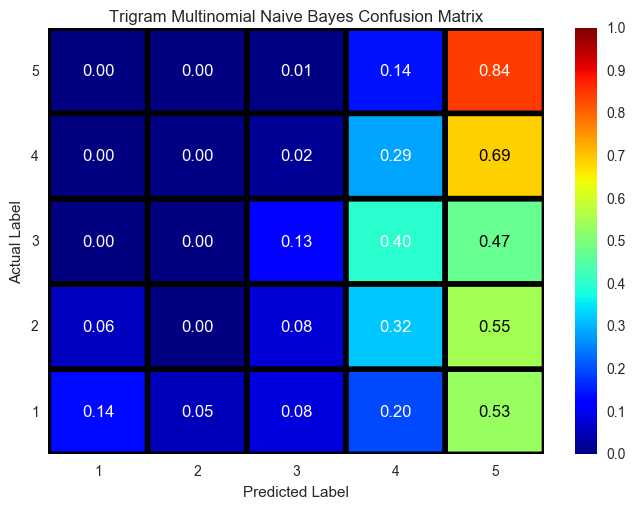

In [191]:
trigram_multinomial_confusion_matrix = confusion_matrix(test_y, tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(trigram_multinomial_confusion_matrix, 'Trigram Multinomial Naive Bayes Confusion Matrix', savefilename='TrigramMultinomialCM.png')


In [192]:
print_classifier_performance_metrics('Trigram Multinomial Naive Bayes', tri_gram_multinomial_nb_prediction)

MODEL: Trigram Multinomial Naive Bayes

Precision: 0.460958537582
Recall: 0.488888888889
F1: 0.428448991211
Accuracy: 0.488888888889

Classification Report:
             precision    recall  f1-score   support

     1 star       0.76      0.14      0.23        96
     2 star       0.00      0.00      0.00        53
     3 star       0.38      0.13      0.19        95
     4 star       0.35      0.29      0.32       250
     5 star       0.54      0.84      0.66       406

avg / total       0.46      0.49      0.43       900


Precision variance: 0.314166

Recall variance: 0.442011


/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

## Bi & Tri Gram Model

In [193]:
bi_and_trigram_multinomial_feature_matrix_train = bi_and_trigram_vectorizer.fit_transform(train_X)
bi_and_trigram_multinomial_feature_matrix_test = bi_and_trigram_vectorizer.transform(test_X)

In [194]:
bi_and_tri_gram_multinomial_nb_classifier = MultinomialNB().fit(bi_and_trigram_multinomial_feature_matrix_train, train_y)
bi_and_tri_gram_multinomial_nb_prediction = bi_and_tri_gram_multinomial_nb_classifier.predict(bi_and_trigram_multinomial_feature_matrix_test)

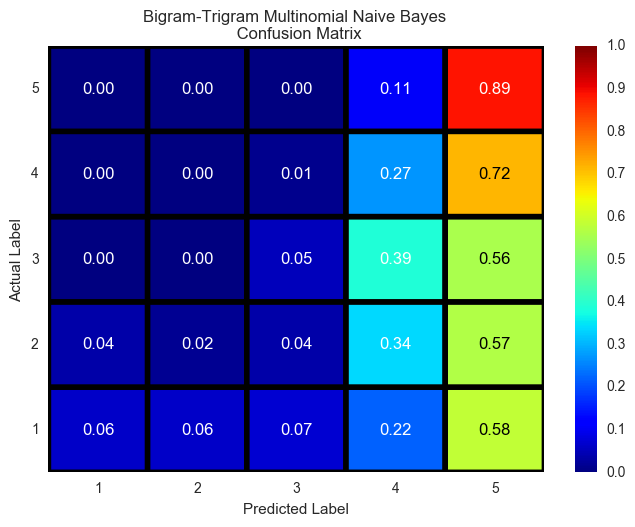

In [195]:
bi_and_tri_gram_multinomial_confusion_matrix = confusion_matrix(test_y, bi_and_tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(bi_and_tri_gram_multinomial_confusion_matrix,
                      'Bigram-Trigram Multinomial Naive Bayes \n Confusion Matrix', savefilename='BiAndTrigramMultinomialCM.png')

In [196]:
print_classifier_performance_metrics('Bi-and-Trigram Multinomial Naive Bayes', bi_and_tri_gram_multinomial_nb_prediction)

MODEL: Bi-and-Trigram Multinomial Naive Bayes

Precision: 0.458046132754
Recall: 0.49
F1: 0.410048869001
Accuracy: 0.49

Classification Report:
             precision    recall  f1-score   support

     1 star       0.75      0.06      0.12        96
     2 star       0.14      0.02      0.03        53
     3 star       0.28      0.05      0.09        95
     4 star       0.36      0.27      0.31       250
     5 star       0.53      0.89      0.67       406

avg / total       0.46      0.49      0.41       900


Precision variance: 0.221544

Recall variance: 0.536137


/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

## The End. 